# 自定义案例：线性拟合

[![下载Notebook](https://gitee.com/mindspore/docs/raw/master/resource/_static/logo_notebook.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/tutorials-develop/tutorials/zh_cn/mindspore_linear_fitting.ipynb)&emsp;[![下载样例代码](https://gitee.com/mindspore/docs/raw/master/resource/_static/logo_download_code.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/tutorials-develop/tutorials/zh_cn/mindspore_linear_fitting.py)&emsp;[![查看源文件](https://gitee.com/mindspore/docs/raw/master/resource/_static/logo_source.png)](https://gitee.com/mindspore/docs/blob/tutorials-develop/tutorials/source_zh_cn/advance/linear_fitting.ipynb)

MindSpore向用户提供了高阶、中阶和低阶3个不同层次的API，详细内容参见[基本介绍-层次结构内容章节](https://www.mindspore.cn/tutorials/zh-CN/master/beginner/introduction.html#层次结构)。

为方便控制网络的执行流程，MindSpore提供了高阶的训练和推理接口`mindspore.Model`，通过指定要训练的神经网络模型和常见的训练设置，调用`train`和`eval`方法对网络进行训练和推理。同时，用户如果想要对特定模块进行个性化设置，也可以调用对应的中低阶接口自行定义网络的训练流程。

本章将使用MindSpore提供的中低阶API拟合线性函数：

$$f(x) = 2x + 3  \tag {1}$$

初始化网络之前，需要配置`context`参数，用于控制程序执行的策略，如配置静态图或动态图模式，配置网络运行的硬件环境等。本章将会介绍配置信息和使用MindSpore提供的中低阶API自定义损失函数、优化器、训练流程、Metric、自定义验证流程模块。

## 配置信息

初始化网络之前，需要配置`context`参数，用于控制程序执行的策略，如配置静态图或动态图模式，配置网络运行的硬件环境等。初始化网络之前要配置`context`参数，用于控制程序执行的策略，本节主要介绍执行模式管理和硬件管理。

### 执行模式

MindSpore支持Graph和PyNative两种运行模式。Graph模式是MindSpore的默认模式，而PyNative模式用于调试等用途。

- Graph模式（静态图模式）：将神经网络模型编译成一整张图，然后下发到硬件执行。该模式利用图优化等技术提高运行性能，同时有助于规模部署和跨平台运行。

- PyNative模式（动态图模式）：将神经网络中的各个算子逐一下发到硬件中执行，该模式方便用户编写代码和调试神经网络模型。

#### 模式选择

通过配置context参数可以控制程序运行的模式。Graph和PyNative两种模式的区别主要有：

- 使用场景：Graph模式需要一开始就构建好网络结构，然后框架做整图优化和执行，比较适合网络固定没有变化，且需要高性能的场景。而PyNative模式逐行执行算子，支持执行单算子、普通函数和网络，以及单独求梯度的操作。

- 网络执行：Graph模式和PyNative模式在执行相同的网络和算子时，精度效果是一致的。由于Graph模式运用了图优化、计算图整图下沉等技术，Graph模式执行网络的性能和效率更高。

- 代码调试：在脚本开发和网络流程调试中，推荐使用PyNative模式进行调试。在PyNative模式下，可以方便地设置断点，获取网络执行的中间结果，也可以通过pdb的方式对网络进行调试。而Graph模式无法设置断点，只能先指定算子进行打印，然后在网络执行完成后查看输出结果。

使用Graph模式时，将context中的运行模式设置为`GRAPH_MODE`，需要使用`nn.Cell`类，并在`construct`函数中编写执行代码，或者调用`@ms_function`装饰器。

#### 模式切换

MindSpore提供了静态图和动态图统一的编码方式，大大增加了静态图和动态图的可兼容性，用户无需开发多套代码，仅变更一行代码便可切换静态图/动态图模式。模式切换时，请留意目标模式的[约束](https://www.mindspore.cn/docs/note/zh-CN/master/static_graph_syntax_support.html)。

> 例如，PyNative模式不支持数据下沉等。

设置运行模式为动态图模式：

In [1]:
from mindspore import context

context.set_context(mode=context.PYNATIVE_MODE)

MindSpore处于静态图模式时，可以通过 `context.set_context(mode=context.PYNATIVE_MODE)`切换为动态图模式；同样，MindSpore处于动态图模式时，可以通过`context.set_context(mode=context.GRAPH_MODE)`切换为静态图模式。

In [2]:
context.set_context(mode=context.GRAPH_MODE)

### 硬件管理

硬件管理部分主要包括`device_target`和`device_id`两个参数。

- `device_target`： 待运行的目标设备，支持`Ascend`、`GPU`和`CPU`，可以根据实际环境情况设置。

- `device_id`： 表示目标设备ID，其值在[0, `device_num_per_host` - 1]范围内，`device_num_per_host`表示服务器的总设备数量，`device_num_per_host`的值不能超过4096，`device_id`默认为0。在非分布式模式执行的情况下，为了避免设备的使用冲突，可以通过设置`device_id`决定程序执行的设备ID。

代码样例如下：

```Python
from mindspore import context

context.set_context(device_target="Ascend", device_id=6)
```

## 生成数据集

定义数据集生成函数 `get_data` ，生成训练数据集和测试数据集。

由于拟合的是线性数据，假定要拟合的目标函数为：$f(x)=2x+3$，那么我们需要的训练数据集应随机分布于函数周边，这里采用了$f(x)=2x+3+noise$的方式生成，其中`noise`为遵循标准正态分布规律的随机数值。

In [3]:
import numpy as np

def get_data(num, w=2.0, b=3.0):
    for _ in range(num):
        x = np.random.uniform(-10.0, 10.0)
        noise = np.random.normal(0, 1)
        y = x * w + b + noise
        yield np.array([x]).astype(np.float32), np.array([y]).astype(np.float32)

使用get_data生成50组验证数据，并可视化。

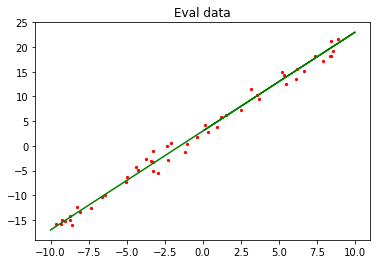

In [4]:
import matplotlib.pyplot as plt

train_data = list(get_data(50))
x_target_label = np.array([-10, 10, 0.1])
y_target_label = x_target_label * 2 + 3
x_eval_label, y_eval_label = zip(*train_data)

plt.scatter(x_eval_label, y_eval_label, color="red", s=5)
plt.plot(x_target_label, y_target_label, color="green")
plt.title("Eval data")
plt.show()

上图中绿色线条部分为目标函数，红点部分为验证数据`train_data`。

## 加载数据集

加载数据集并对数据进行处理。

- `ds.GeneratorDataset`：将生成的数据转换为MindSpore的数据集，并且将生成的数据的x，y值存入到`data`和`label`的数组中。
- `batch`：将`batch_size`个数据组合成一个batch。
- `repeat`：将数据集数量倍增。

In [5]:
from mindspore import dataset as ds

def create_dataset(num_data, batch_size=16, repeat_size=1):
    input_data = ds.GeneratorDataset(list(get_data(num_data)), column_names=['data', 'label'])
    input_data = input_data.batch(batch_size, drop_remainder=True)
    input_data = input_data.repeat(repeat_size)
    return input_data

使用数据集增强函数生成训练数据，通过定义的`create_dataset`将生成的1600个数据增强为100组shape为16x1的数据集。

In [6]:
data_number = 1600
batch_number = 16
repeat_number = 1

ds_train = create_dataset(data_number, batch_size=batch_number, repeat_size=repeat_number)
print("The dataset size of ds_train:", ds_train.get_dataset_size())
step_size = ds_train.get_dataset_size()
dict_datasets = next(ds_train.create_dict_iterator())

print(dict_datasets.keys())
print("The x label value shape:", dict_datasets["data"].shape)
print("The y label value shape:", dict_datasets["label"].shape)

The dataset size of ds_train: 100
dict_keys(['data', 'label'])
The x label value shape: (16, 1)
The y label value shape: (16, 1)


## 定义线性神经网络模型

mindspore.nn`类是构建所有网络的基类，也是网络的基本单元。当用户需要自定义网络时，可以继承`nn.Cell`类，并重写`__init__`方法和`construct`方法。`mindspore.ops`模块提供了基础算子的实现，`nn.Cell`模块实现了对基础算子的进一步封装，用户可以根据需要，灵活使用不同的算子。

如下示例使用`nn.Cell`构建一个简单的全连接网络，用于后续自定义内容的示例片段代码。

在MindSpore中使用`nn.Dense`生成单个数据输入，单个数据输出的线性函数模型：

$$f(x)=wx+b\tag{2}$$

并使用Normal算子随机初始化权重$w$和$b$。

In [7]:
from mindspore import nn
from mindspore.common.initializer import Normal

class LinearNet(nn.Cell):
    def __init__(self):
        super(LinearNet, self).__init__()
        self.fc = nn.Dense(1, 1, Normal(0.02), Normal(0.02))

    def construct(self, x):
        x = self.fc(x)
        return x

初始化网络模型后，接下来将初始化的网络函数和训练数据集进行可视化，了解拟合前的模型函数情况。

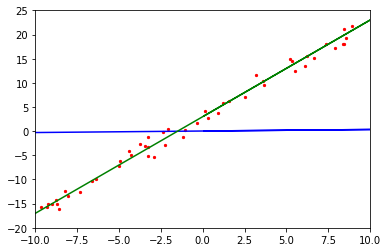

In [8]:
from mindspore import Tensor

# 初始化线性回归网络
net = LinearNet()
# 获取训练前的网络参数w和b
model_params = net.trainable_params()

x_model_label = np.array([-10, 10, 0.1])
y_model_label = (x_model_label * Tensor(model_params[0]).asnumpy()[0][0] +
                 Tensor(model_params[1]).asnumpy()[0])

plt.axis([-10, 10, -20, 25])
plt.scatter(x_eval_label, y_eval_label, color="red", s=5)
plt.plot(x_model_label, y_model_label, color="blue")
plt.plot(x_target_label, y_target_label, color="green")
plt.show()

## 自定义损失函数

损失函数（Loss Function）用于衡量预测值与真实值差异的程度。深度学习中，模型训练就是通过不停地迭代来缩小损失函数值的过程，因此在模型训练过程中损失函数的选择非常重要，定义一个好的损失函数可以帮助损失函数值更快收敛，达到更好的精度。

[mindspore.nn](https://www.mindspore.cn/docs/api/zh-CN/master/api_python/mindspore.nn.html#id13)提供了许多通用损失函数供用户选择， 也支持用户根据需要自定义损失函数。

自定义损失函数类时，既可以继承网络的基类`nn.Cell`，也可以继承损失函数的基类`nn.LossBase`。`nn.LossBase`在`nn.Cell`的基础上，提供了`get_loss`方法，利用`reduction`参数对损失值求和或求均值，输出一个标量。下面将使用继承LossBase的方法来定义平均绝对误差损失函数(Mean Absolute Error，MAE)，MAE算法的公式如下所示：

$$ loss= \frac{1}{m}\sum_{i=1}^m\lvert y_i-f(x_i) \rvert $$

上式中$f(x)$为预测值，$y$为样本真实值，$loss$为预测值与真实值之间距离的平均值。

使用继承LossBase的方法来自定义损失函数时，需要重写`__init__`方法和`construct`方法，使用`get_loss`方法计算损失。示例代码如下：

In [9]:
from mindspore import nn, ops

class MyMAELoss(nn.LossBase):
    """定义损失"""
    def __init__(self, reduction="mean"):
        super(MyMAELoss, self).__init__(reduction)
        self.abs = ops.Abs()

    def construct(self, predict, target):
        x = self.abs(predict - target)
        return self.get_loss(x)

## 自定义优化器

优化器在模型训练过程中，用于计算和更新网络参数，合适的优化器可以有效减少训练时间，提高模型性能。

[mindspore.nn](https://www.mindspore.cn/docs/api/zh-CN/master/api_python/mindspore.nn.html#id14)提供了许多通用的优化器供用户选择，同时也支持用户根据需要自定义优化器。

自定义优化器时可以继承优化器基类`nn.Optimizer`，重写`__init__`方法和`construct`方法实现参数的更新。

如下示例实现自定义优化器Momentum：

$$ v_{t+1} = v_t×u+grad $$

带有动量的SGD算法：

$$p_{t+1} = p_t - lr*v_{t+1}$$

使用Nesterov动量的SGD算法:

$$p_{t+1} = p_t-(grad+v_{t+1}*u)×lr $$

其中，grad 、lr 、p 、v 和 u 分别表示梯度、学习率、参数、矩（Moment）和动量（Momentum）。

In [10]:
from mindspore import Tensor, Parameter
from mindspore import nn, ops
from mindspore import dtype as mstype

class MyMomentum(nn.Optimizer):
    """定义优化器"""
    def __init__(self, params, learning_rate, momentum=0.9, use_nesterov=False):
        super(MyMomentum, self).__init__(learning_rate, params)
        self.momentum = Parameter(Tensor(momentum, mstype.float32), name="momentum")
        self.use_nesterov = use_nesterov
        self.moments = self.parameters.clone(prefix="moments", init="zeros")
        self.assign = ops.Assign()

    def construct(self, gradients):
        """construct输入为梯度，在训练中自动传入梯度gradients"""
        lr = self.get_lr()
        # 待更新的权重参数
        params = self.parameters
        for i in range(len(params)):
            # 更新moments值
            self.assign(self.moments[i], self.moments[i] * self.momentum + gradients[i])
            if self.use_nesterov:
                # 使用Nesterov动量的SGD算法:
                update = params[i] - (self.moments[i] * self.momentum + gradients[i]) * lr
            else:
                # 带有动量的SGD算法
                update = params[i] - self.moments[i] * lr
            # 更新params值为update值
            self.assign(params[i], update)
        return params

## 自定义训练流程

`mindspore.Model`提供了`train`和`eval`的接口方便用户在训练过程中使用，但此接口无法适用于所有场景，比如多数据多标签场景，在这些场景下用户需自行定义训练过程。本节主要使用线性回归的例子来简单介绍自定义训练流程。首先定义损失网络，将前向网络与损失函数连接起来；然后定义训练流程，训练流程一般继承`nn.TrainOneStepCell`，`nn.TrainOneStepCell`封装了损失网络和优化器，用来实现反向传播网络以更新权重参数。

### 定义损失网络

定义损失网络`MyWithLossCell`，将前向网络与损失函数连接起来。

In [11]:
class MyWithLossCell(nn.Cell):
    """定义损失网络"""

    def __init__(self, backbone, loss_fn):
        """实例化时传入前向网络和损失函数作为参数"""
        super(MyWithLossCell, self).__init__(auto_prefix=False)
        self.backbone = backbone
        self.loss_fn = loss_fn

    def construct(self, data, label):
        """连接前向网络和损失函数"""
        out = self.backbone(data)
        return self.loss_fn(out, label)

    def backbone_network(self):
        """要封装的骨干网络"""
        return self.backbone

### 定义训练流程

定义训练流程`MyTrainStep`，该类继承`nn.TrainOneStepCell`，`nn.TrainOneStepCell`封装了损失网络和优化器，在执行训练时通过`ops.GradOperation`算子来进行梯度的获取，通过优化器来实现权重的更新。

In [12]:
class MyTrainStep(nn.TrainOneStepCell):
    """定义训练流程"""

    def __init__(self, network, optimizer):
        """参数初始化"""
        super(MyTrainStep, self).__init__(network, optimizer)
        self.grad = ops.GradOperation(get_by_list=True)

    def construct(self, data, label):
        """构建训练过程"""
        weights = self.weights
        loss = self.network(data, label)
        grads = self.grad(self.network, weights)(data, label)
        return loss, self.optimizer(grads)

### 定义绘图函数

定义绘图函数`plot_model_and_datasets`绘制测试数据、目标函数和网络模型拟合函数，并查看损失值。

In [13]:
import matplotlib.pyplot as plt
import time


def plot_model_and_datasets(net, data, loss):
    weight = net.trainable_params()[0]
    bias = net.trainable_params()[1]
    x = np.arange(-10, 10, 0.1)
    y = x * Tensor(weight).asnumpy()[0][0] + Tensor(bias).asnumpy()[0]
    x1, y1 = zip(*data)
    x_target = x
    y_target = x_target * 2 + 3

    plt.axis([-11, 11, -20, 25])
    # 原始数据
    plt.scatter(x1, y1, color="red", s=5)
    # 预测数据
    plt.plot(x, y, color="blue")
    # 拟合函数
    plt.plot(x_target, y_target, color="green")
    # 打印损失值
    plt.title(f"Loss:{loss}")

    plt.show()
    time.sleep(0.2)
    display.clear_output(wait=True)

### 执行训练

使用训练数据`ds_train`对训练网络`train_net`进行训练，并可视化训练过程。

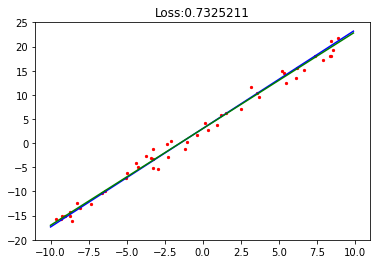

In [14]:
from IPython import display

# 损失函数
loss_func = MyMAELoss()
# 优化器
opt = MyMomentum(net.trainable_params(), 0.01)
# 构建损失网络
net_with_criterion = MyWithLossCell(net, loss_func)
# 构建训练网络
train_net = MyTrainStep(net_with_criterion, opt)

for data in ds_train.create_dict_iterator():
    # 执行训练，并更新权重
    train_net(data['data'], data['label'])
    # 损失值
    loss = net_with_criterion(data['data'], data['label'])
    # 可视化训练过程
    plot_model_and_datasets(train_net, train_data, loss)

## 自定义评价指标

当训练任务结束，常常需要评价指标（Metrics）评估函数来评估模型的好坏。常用的评价指标混淆矩阵、准确率 Accuracy、精确率 Precision、召回率 Recall等。

[mindspore.nn](https://www.mindspore.cn/docs/api/zh-CN/master/api_python/mindspore.nn.html#id16)模块提供了常见的评估函数，用户也可以根据需要自行定义评估指标。自定义Metrics函数需要继承`nn.Metric`父类，并重新实现父类中的`clear`方法、`update`方法和`eval`方法。平均绝对误差（MAE）算法如下式所示，下面以简单的MAE为例，介绍这三个函数及其使用方法。

$$ MAE=\frac{1}{n}\sum_{i=1}^n\lvert ypred_i - y_i \rvert$$

- `clear`：初始化相关的内部参数。
- `update`：接收网络预测输出和标签，计算误差，并更新内部评估结果。一般在每个step后进行计算，并更新统计值。
- `eval`：计算最终评估结果，一般在一个epoch结束后计算最终的评估结果。

In [25]:
class MyMAE(nn.Metric):
    """定义metric"""

    def __init__(self):
        super(MyMAE, self).__init__()
        self.clear()

    def clear(self):
        """初始化变量abs_error_sum和samples_num"""
        self.abs_error_sum = 0
        self.samples_num = 0

    def update(self, *inputs):
        """更新abs_error_sum和samples_num"""
        if len(inputs) != 2:
            raise ValueError('Mean absolute error need 2 inputs (y_pred, y), but got {}'.format(len(inputs)))
        # 将Tensor转换为NumPy，便于后续计算
        y_pred = inputs[0].asnumpy()
        y = inputs[1].asnumpy()
        # 计算预测值与真实值的绝对误差
        error_abs = np.abs(y.reshape(y_pred.shape) - y_pred)
        self.abs_error_sum += error_abs.sum()
        # 样本的总数
        self.samples_num += y.shape[0]

    def eval(self):
        """计算最终评估结果"""
        if self.samples_num == 0:
            raise RuntimeError('Total samples num must not be 0.')
        return self.abs_error_sum / self.samples_num

## 自定义验证流程

mindspore.nn模块提供了评估网络包装函数[nn.WithEvalCell](https://www.mindspore.cn/docs/api/zh-CN/master/api_python/nn/mindspore.nn.WithEvalCell.html#mindspore.nn.WithEvalCell)，由于`nn.WithEvalCell`只有两个输入`data`和`label`，不适用于多数据或多标签的场景，所以需要自定义评估网络。多标签场景下自定义评估网络可参考[自定义评估与训练章节](https://www.mindspore.cn/tutorials/zh-CN/master/advance/network/custom_train_and_eval_net.html#自定义评估网络)。

如下示例实现简单的自定义评估网络`MyWithEvalCell`，输入传入数据`data`和标签`label`:

In [26]:
class MyWithEvalCell(nn.Cell):
    """定义验证流程"""

    def __init__(self, network):
        super(MyWithEvalCell, self).__init__(auto_prefix=False)
        self.network = network

    def construct(self, data, label):
        outputs = self.network(data)
        return outputs, label

执行推理并评估：


In [27]:
data_number = 160
batch_number = 16
repeat_number = 1
# 获取验证数据
ds_eval = create_dataset(data_number, batch_size=batch_number, repeat_size=repeat_number)
# 定义评估网络
eval_net = MyWithEvalCell(net)
eval_net.set_train(False)
# 定义评估指标
mae = MyMAE()

# 执行推理过程
for data in ds_eval.create_dict_iterator():
    output, eval_y = eval_net(data['data'], data['label'])
    mae.update(output, eval_y)

mae_result = mae.eval()
print("MAE: ", mae_result)

MAE:  0.7791957974433898


输出评估误差，MAE与模型在训练集上效果大致相同。

## 保存及导出模型

将上述训练好的模型参数保存到CheckPoint(简称ckpt)文件中，然后将CheckPoint文件导出为MindIR格式文件用于跨平台推理使用。

In [24]:
import numpy as np
from mindspore import save_checkpoint, load_checkpoint, export

# 将模型参数保存在ckpt文件
save_checkpoint(net, "./linear.ckpt")
# 将模型参数存入param_dict字典中
param_dict = load_checkpoint("./linear.ckpt")
# 查看模型参数
for param in param_dict:
    print(param, ":", param_dict[param].asnumpy())

# 定义线性网络
net1 = LinearNet()
input_np = np.random.uniform(0.0, 1.0, size=[1, 1]).astype(np.float32)
export(net1, Tensor(input_np), file_name='linear', file_format='MINDIR')

fc.weight : [[2.0361092]]
fc.bias : [3.0202212]
